In [25]:
import numpy as np
import pandas as pd
from collections.abc import Iterable
import numbers
import copy
import plotly.graph_objects as go
import math

In [7]:
class MLP_with_backpropagation():
    
    def identity(x):
        return x
    def derivative_sv(function, x, dx=10**(-6)):
        return (function(x+dx)-function(x))/dx
        
    def __init__(self, shape, activations = None): #len(activations)+1=len(shape)
        fed_values = []
        activation_values = []
        for layer_size in shape:
            fed_values.append(np.array([0]*layer_size))
            activation_values.append(np.array([0]*layer_size))
        self.fed_values = fed_values
        self.activation_values = activation_values
        #first layer values are set so that indexes match
        weights = [0]
        biases = [0]
        for i in range(1, len(self.fed_values)):
            n = len(self.fed_values[i])
            m = len(self.fed_values[i-1])
            #initialising with random values
            weight_matrix = np.random.normal(0,1,(n,m))
            weights.append(weight_matrix)
            bias_vector = np.random.normal(0,1,n)
            biases.append(bias_vector)
        self.weights = weights
        self.biases = biases
        
        if activations:
            self.activations = [0] + [np.vectorize(activation) for activation in activations]
            self.activations_sv = [0] + [activation for activation in activations]
        else:
            self.activations = [0] + [np.vectorize(MLP_with_backpropagation.identity)] * (len(shape) - 1)
            self.activations_sv = [0] + [MLP_with_backpropagation.identity] * (len(shape) - 1)
            
    #2 functions below are only for technical purposes
    def is_iterable(obj):
        return isinstance(obj, Iterable)

    def is_numeric_vector_of_given_length(supposed_vector, length):
         if not MLP_with_backpropagation.is_iterable(supposed_vector):
             return False
         if len(supposed_vector) != length:
             return False
         for el in supposed_vector:
             if not isinstance(el, numbers.Number):
                 return False
         return True
        
    def set_input(self, inputt):
        if not MLP_with_backpropagation.is_numeric_vector_of_given_length(inputt, len(self.fed_values[0])):
            print("Wrong input size or type, it is supposed to be a numerical list or a 1D np.array of length of 1st layer")
            return False
        self.fed_values[0] = np.array(inputt)
        self.activation_values[0] = np.array(inputt) #input is input
        return True
        
    def feed_forward(self):
        for i in range(1, len(self.fed_values)):
            self.fed_values[i] = np.dot(self.weights[i], self.activation_values[i-1]) + self.biases[i] ##can do if statement if activation is function of layer not neuron
            self.activation_values[i] = self.activations[i](self.fed_values[i])

    def predict(self, x):
        if not self.set_input(x):
            return False
        self.feed_forward()
        return self.activation_values[-1]

    def predict_multiple(self, x):
        y = []
        for el in x:
            y.append(self.predict(el))
        return np.array(y)
        
    #manual setting of weights and biases    
    def set_weights(self, weights):
        self.weights = weights

    def set_biases(self, biases):
        self.biases = biases

    def squared_error(pred, expected):
        return (expected - pred)**2

    
    #returns a pair first element is for weights second for biases
    def backpropagate(self, inputt, expected):
        self.predict(inputt)
        dx = 10**(-6)
        weight_grad = [0] + [np.zeros(self.weights[i].shape) for i in range(1, len(self.weights))]
        bias_grad = [0] + [np.zeros(len(self.biases[i])) for i in range(1, len(self.biases))]
        neuron_activation_grad = [0] + [np.zeros(len(self.activation_values[i])) for i in range(1, len(self.activation_values))]
        neuron_fed_grad = [0] + [np.zeros(len(self.fed_values[i])) for i in range(1, len(self.fed_values))]
        last_layer = True
        for i in range(len(self.fed_values)-1, 0, -1):
            #derivatives in respect to neuron activation values
            for j in range(len(self.activation_values[i])):
                if last_layer:
                    x_0 = self.activation_values[i][j]
                    y_0 = expected[j]
                    neuron_activation_grad[i][j] = 2*(x_0-y_0)
                    # print(dc_da(x_0, y_0))
                else:
                    neuron_activation_grad[i][j] = sum([neuron_fed_grad[i+1][k] * self.weights[i+1][k][j] for k in range(len(neuron_fed_grad[i+1]))])
                                                 
                neuron_fed_grad[i][j] = neuron_activation_grad[i][j]*MLP_with_backpropagation.derivative_sv(self.activations_sv[i], self.fed_values[i][j])
                bias_grad[i][j] = neuron_fed_grad[i][j]
                
                for k in range(len(self.weights[i][j])):
                    weight_grad[i][j][k] = neuron_fed_grad[i][j] * self.activation_values[i-1][k]
            last_layer = False
        return (weight_grad, bias_grad)

    def add_2_lists_of_np_arrays(l1, l2):
        for i in range(len(l1)):
            l1[i] += l2[i]
        return l1
        
    def subtract_2_lists_of_np_arrays(l1, l2):
        for i in range(len(l1)):
            l1[i] -= l2[i]
        return l1
        
    def create_0filled_list_of_np_arrays(lista):
        listr = [0]
        for i in range(1, len(lista)):
            listr.append(np.zeros(lista[i].shape))
        return listr

    def multiply_list_elementwise(lista, factor):
        for i in range(len(lista)):
            lista[i] = lista[i] * factor
        return lista

    def learn_batch(self, batchx, batchy, lr):
        batch_size = len(batchx)
        for i in range(batch_size):
            local_weight_gradient, local_bias_gradient = self.backpropagate(batchx[i], batchy[i])
            if i==0:
                avg_weight_gradient = MLP_with_backpropagation.create_0filled_list_of_np_arrays(local_weight_gradient)
                avg_bias_gradient = MLP_with_backpropagation.create_0filled_list_of_np_arrays(local_bias_gradient)
            avg_weight_gradient = MLP_with_backpropagation.add_2_lists_of_np_arrays(avg_weight_gradient, local_weight_gradient)
            avg_bias_gradient = MLP_with_backpropagation.add_2_lists_of_np_arrays(avg_bias_gradient, local_bias_gradient)
        avg_weight_gradient = MLP_with_backpropagation.multiply_list_elementwise(avg_weight_gradient, 1/batch_size)
        avg_bias_gradient = MLP_with_backpropagation.multiply_list_elementwise(avg_bias_gradient, 1/batch_size)
        self.weights = MLP_with_backpropagation.subtract_2_lists_of_np_arrays(self.weights, MLP_with_backpropagation.multiply_list_elementwise(avg_weight_gradient, lr))
        self.biases = MLP_with_backpropagation.subtract_2_lists_of_np_arrays(self.biases, MLP_with_backpropagation.multiply_list_elementwise(avg_bias_gradient, lr))

    def epoch(self, x, y, lr=0.01, batch_size = None):
        permutation = np.random.permutation(len(x))
        x_sh=x[permutation]
        y_sh=y[permutation]
        if not batch_size:
            batch_size = min(32, len(x))
        idx = 0 
        while(idx + batch_size < len(x)):
            batchx = x_sh[idx:idx+batch_size]
            batchy = y_sh[idx:idx+batch_size]
            self.learn_batch(batchx, batchy, lr)
            idx+=batch_size
        if idx != len(x)-1:
            batchx = x_sh[idx:]
            batchy = y_sh[idx:]
            self.learn_batch(batchx, batchy, lr)
        
            
            

    # def learn(self, x, y, epochs, lr=0.01, batch_size = None):
    #         if not batch_size:
    #             batch_size = max(1,int(len(x)/100))
    #         for i in range(epochs):
    #             idx = 0
    #             permutation = np.random.permutation(len(x))
    #             x_sh=x[permutation]
    #             y_sh=y[permutation]
    #             while(idx + batch_size < len(x)):
    #                 batchx = x_sh[idx:idx+batch_size]
    #                 batchy = y_sh[idx:idx+batch_size]
    #                 for i in range(batch_size):
    #                     local_weight_gradient, local_bias_gradient = self.backpropagate(batchx[i], batchy[i])
    #                     if i==0:
    #                         avg_weight_gradient = MLP_with_backpropagation.create_0filled_list_of_np_arrays(local_weight_gradient)
    #                         avg_bias_gradient = MLP_with_backpropagation.create_0filled_list_of_np_arrays(local_bias_gradient)
    #                     avg_weight_gradient = MLP_with_backpropagation.add_2_lists_of_np_arrays(avg_weight_gradient, local_weight_gradient)
    #                     avg_bias_gradient = MLP_with_backpropagation.add_2_lists_of_np_arrays(avg_bias_gradient, local_bias_gradient)
    #                 avg_weight_gradient = MLP_with_backpropagation.multiply_list_elementwise(avg_weight_gradient, 1/batch_size)
    #                 avg_bias_gradient = MLP_with_backpropagation.multiply_list_elementwise(avg_bias_gradient, 1/batch_size)
    #                 self.weights = MLP_with_backpropagation.subtract_2_lists_of_np_arrays(self.weights, MLP_with_backpropagation.multiply_list_elementwise(avg_weight_gradient, lr))
    #                 self.biases = MLP_with_backpropagation.subtract_2_lists_of_np_arrays(self.biases, MLP_with_backpropagation.multiply_list_elementwise(avg_bias_gradient, lr))
    #                 idx += batch_size
        

    
            
        

In [33]:
def sigmoid(x):
    return 1/(1+math.exp(-x))
def relu(x):
    return max(x,0)
def MSE0_learn_MSE1(network, X_train, Y_train, X_test, Y_test, epochs):
    max_x = max(X_train)
    min_x = min(X_train)
    max_y = max(Y_train)
    min_y = min(Y_train)
    x_scl = max_x - min_x
    y_scl = max_y - min_y
    X_tr_scl = X_train / x_scl
    Y_tr_scl = Y_train / y_scl
    X_ts_scl = X_test / x_scl
    Y_ts_scl = Y_test / y_scl
    pred0 = network.predict_multiple(X_ts_scl.reshape(-1,1)) * y_scl
    MSE0 = sum((Y_test - pred0.reshape(-1))**2)/len(X_train)
    network.learn(X_tr_scl.reshape(-1,1), Y_tr_scl.reshape(-1,1), epochs, 0.1)
    pred1 = network.predict_multiple(X_ts_scl.reshape(-1,1)) * y_scl
    MSE1 = sum((Y_test - pred1.reshape(-1))**2)/len(X_train)
    return MSE0, MSE1, pred0, pred1

    
network = MLP_with_backpropagation([1,5, 5, 1], [sigmoid, sigmoid, MLP_with_backpropagation.identity])
# train = pd.read_csv("data/regression/square-simple-training.csv")
# test = pd.read_csv("data/regression/square-simple-test.csv")
train = pd.read_csv("data/regression/multimodal-large-training.csv")
test = pd.read_csv("data/regression/multimodal-large-test.csv")
X_train = train['x'].values
Y_train = train['y'].values
X_test = test['x'].values
Y_test = test['y'].values

max_x = max(X_train)
min_x = min(X_train)
max_y = max(Y_train)
min_y = min(Y_train)
x_scl = max_x - min_x
y_scl = max_y - min_y
X_tr_scl = (X_train - min_x) / x_scl
Y_tr_scl = (Y_train - min_y) / y_scl
X_ts_scl = (X_test - min_x) / x_scl
Y_ts_scl = (Y_test -min_y) / y_scl
pred0 = network.predict_multiple(X_ts_scl.reshape(-1,1)).reshape(-1) * y_scl + min_y
MSE0 = sum((Y_test - pred0)**2)/len(X_train)
print(MSE0)


19748.17474776035


In [40]:
for i in range(100):
    network.epoch(X_tr_scl.reshape(-1,1), Y_tr_scl.reshape(-1,1), 0.005)
    pred = network.predict_multiple(X_ts_scl.reshape(-1,1)).reshape(-1) * y_scl + min_y
    MSE = sum((Y_test - pred)**2)/len(X_train)
    if i % 10 == 0:
        print(MSE)
        
        


261.13018794309966
259.2455882162189
259.56389571039693
259.14331166783285
259.2171383436531
259.8135935294609
259.0896556472739
259.2148463399938
259.2154293338583
258.9260139150007


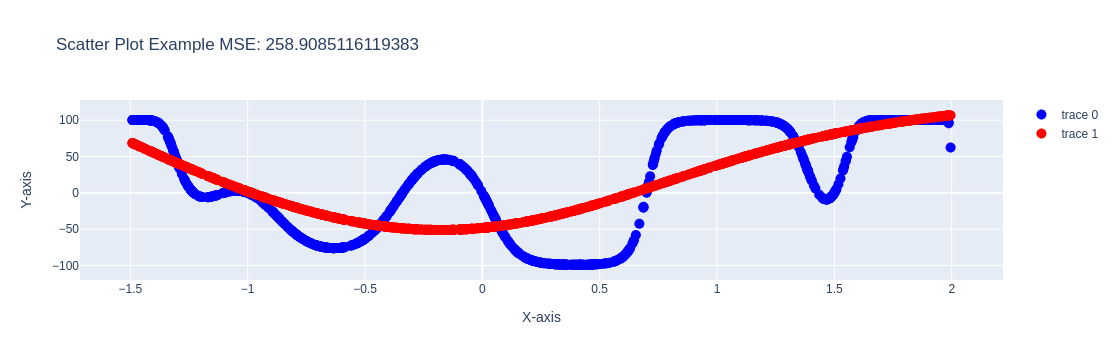

In [41]:
fig = go.Figure(data=go.Scatter(x=X_test, y=Y_test, mode='markers', marker=dict(color='blue', size=10)))

fig.add_trace(go.Scatter(x=X_test, y=pred.reshape(-1), mode='markers', marker=dict(color='red', size=10)))
# fig.add_trace(go.Scatter(x=X_test, y=pred0.reshape(-1), mode='markers', marker=dict(color='green', size=10)))

fig.update_layout(title=f"Scatter Plot Example MSE: {MSE}", xaxis_title="X-axis", yaxis_title="Y-axis")

fig.show()

3.600772621089712


-5.3574224


array([1.32128885])

np.float64(-129.988852338856)

In [183]:
network.activations_sv

[0,
 <function __main__.sigmoid(x)>,
 <function __main__.MLP_with_backpropagation.identity(x)>]

In [3]:
x = [i for i in range(11)]

In [5]:
x[9:]

[9]